In [3]:
import pandas as pd
import quandl
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
X = 5
initialize_date = "2016-01-01"

In [5]:
historical_marketcap = pd.read_csv("data.csv").drop_duplicates(subset=['Symbol','Date'], keep='first')
historical_marketcap = historical_marketcap.loc[historical_marketcap['Is Mined'] == True]
x_historical_marketcap = historical_marketcap.groupby('Date', as_index=False).apply(lambda x: x.nlargest(X, 'Market Cap'))
ts_hist_cap = x_historical_marketcap.pivot(index='Date', columns='Symbol', values='Market Cap')
ts_hist_cap.index = pd.to_datetime(ts_hist_cap.index)
ts_hist_cap.sort_index(inplace=True)
ts_hist_cap = ts_hist_cap.loc[initialize_date:]
ts_hist_cap.dropna(axis=1, how='all', thresh=None, subset=None, inplace=True)
if "MIOTA" in ts_hist_cap.columns:
    ts_hist_cap.rename(index=str, columns={"MIOTA":"IOT"}, inplace=True)

ts_hist_cap.head()

Symbol,BCH,BTC,BTG,DASH,DOGE,EMC,ETC,ETH,LTC,XMR
Date,,,,,,,,,,
2016-01-03,NaN,6.487951e+09,NaN,19820453.0,15091783.0,NaN,NaN,72409494.0,153184845.0,NaN
2016-01-10,NaN,6.695068e+09,NaN,19254557.0,17805476.0,NaN,NaN,74621507.0,155022614.0,NaN
2016-01-17,NaN,5.810702e+09,NaN,24030404.0,15766176.0,NaN,NaN,94185825.0,135127839.0,NaN
2016-01-24,NaN,5.921312e+09,NaN,27784763.0,17812262.0,NaN,NaN,163842855.0,138289448.0,NaN
2016-01-31,NaN,5.747894e+09,NaN,25429609.0,25295002.0,NaN,NaN,189559249.0,137354970.0,NaN


In [6]:
mined_currencies = list(ts_hist_cap.columns)
mined_currencies = ["LTC","BTC","ETH"]
print(mined_currencies)
altfundx_currencies = mined_currencies
ts_hist_cap = ts_hist_cap[altfundx_currencies]
ts_hist_cap.head()

['LTC', 'BTC', 'ETH']


Symbol,LTC,BTC,ETH
Date,,,
2016-01-03,153184845.0,6.487951e+09,72409494.0
2016-01-10,155022614.0,6.695068e+09,74621507.0
2016-01-17,135127839.0,5.810702e+09,94185825.0
2016-01-24,138289448.0,5.921312e+09,163842855.0
2016-01-31,137354970.0,5.747894e+09,189559249.0


In [7]:
quandl.ApiConfig.api_key = '-GNvgv_nqBHeqiyEQjyj'
symbol_usd_pairs = {x:None for x in mined_currencies}

for symbol in altfundx_currencies:
    bnc_symbol_1 = "MWA_{}_USD".format(symbol)
    bnc_symbol_2 = "MWA_{}_BTC_USD".format(symbol)
    bnc_symbol_3 = "MWA_{}_ETH_USD".format(symbol)
    all_bnc = [
        bnc_symbol_1,
        bnc_symbol_2,
        bnc_symbol_3
    ]
    for bnc_symbol in all_bnc:
        try:
            data = quandl.get("BNC2/"+bnc_symbol)
            break
        except:
            bnc_symbol = None
    if bnc_symbol:
        print("For Currency {} - BNC symbol is {}".format(symbol, bnc_symbol))
    else:
        print("For Currency {} - No BNC symbol".format(symbol))
    symbol_usd_pairs[symbol] = bnc_symbol

print(symbol_usd_pairs)

For Currency LTC - BNC symbol is MWA_LTC_USD
For Currency BTC - BNC symbol is MWA_BTC_USD
For Currency ETH - BNC symbol is MWA_ETH_USD
{'LTC': 'MWA_LTC_USD', 'ETH': 'MWA_ETH_USD', 'BTC': 'MWA_BTC_USD'}


In [8]:
ts_hist_cap.index.min()

Timestamp('2016-01-03 00:00:00')

In [9]:
hist_pricing = {x:None for x in altfundx_currencies}
for altfundx_instrument in symbol_usd_pairs:
    df0 = quandl.get("BNC2/"+symbol_usd_pairs[altfundx_instrument], start_date=ts_hist_cap.index.min())
    df = pd.DataFrame(df0, columns=["VWAP"])
    #print(altfundx_instrument)
    #print(df.head())
    df.columns = ["PRICE"]
    df.index.rename("DATETIME", inplace=True)
    hist_pricing[altfundx_instrument] = df

In [10]:

ts_hist_cap_pct = ts_hist_cap.div(ts_hist_cap.sum(1),0)
ts_hist_cap_pct.head()

Symbol,LTC,BTC,ETH
Date,,,
2016-01-03,0.022817,0.966397,0.010786
2016-01-10,0.022387,0.966837,0.010776
2016-01-17,0.022372,0.962034,0.015594
2016-01-24,0.022221,0.951453,0.026327
2016-01-31,0.022611,0.946185,0.031204


In [11]:
from functools import reduce

values_dict = {x:None for x in ts_hist_cap_pct.columns}
values_list = []

for asset in ts_hist_cap_pct.columns:
    #asset = "BTC"
    weight_price_df = ts_hist_cap_pct[[asset]].merge(hist_pricing[asset], right_index=True, left_index=True, how="outer").fillna(method='ffill')
    value_df0 = (weight_price_df[asset] * weight_price_df["PRICE"])
    value_df = pd.DataFrame(value_df0, columns=[asset])
    value_df.columns = [asset]
    value_df.index.rename("Date", inplace=True)
    #print(value_df.head())
    values_list.append(value_df)

index_values = reduce(lambda df1, df2: df1.merge(df2, "outer", right_index=True, left_index=True), values_list)
index_values.head()

,LTC,BTC,ETH
Date,,,
2016-01-03,0.079036,415.841449,0.011257
2016-01-04,0.079247,417.815412,0.010235
2016-01-05,0.079090,419.339742,0.009959
2016-01-06,0.078712,417.132328,0.010245
2016-01-07,0.081003,435.797228,0.010312


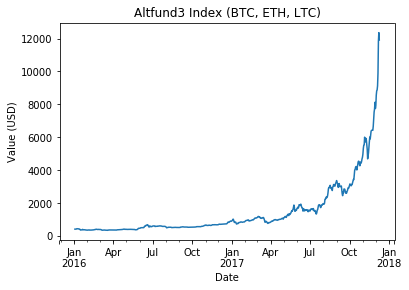

In [12]:
index_values.sum(axis=1).plot()
plt.ylabel('Value (USD)')
plt.title('Altfund3 Index (BTC, ETH, LTC)')
plt.savefig('Altfund3.png')
plt.show()

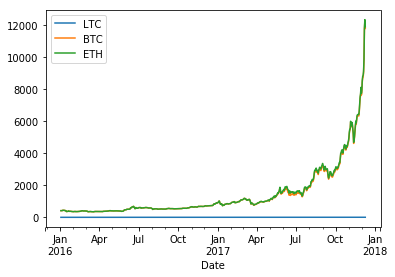

In [13]:
#plt.stackplot(index_values.index,*[ts for col, ts in index_values.iteritems()])
#plt.show()
index_values.plot(stacked=True)

In [14]:
current_marketcap = pd.read_csv("coinmarketcap_ticker_data_dump.csv")
current_marketcap.head()

,ID,NAME,SYMBOL,RANK,PRICE_USD,PRICE_BTC,24H_VOLUMNE_USD,MARKET_CAP_USD,AVAILABLE SUPPLY,TOTAL_SUPPLY,MAX_SUPPLY,%1HR,%24HR,%7D,LAST UPDATED,TIMESTAMP
0,bitcoin,Bitcoin,BTC,1,11153.700000,1.000000,5.231050e+09,1.864429e+11,1.671579e+07,1.671579e+07,2.100000e+07,0.17,1.91,27.38,1512253450,2017-12-02 22:26:08.632507
1,ethereum,Ethereum,ETH,2,465.142000,0.042249,9.777450e+08,4.469790e+10,9.609518e+07,9.609518e+07,NaN,-0.00,-0.54,-0.40,1512253455,2017-12-02 22:26:08.632569
2,bitcoin-cash,Bitcoin Cash,BCH,3,1451.000000,0.131796,5.887420e+08,2.442655e+10,1.683429e+07,1.683429e+07,2.100000e+07,-0.36,-0.71,-8.87,1512253473,2017-12-02 22:26:08.632592
3,ripple,Ripple,XRP,4,0.255639,0.000023,1.250330e+08,9.873512e+09,3.862287e+10,9.999317e+10,1.000000e+11,0.11,-0.52,1.32,1512253441,2017-12-02 22:26:08.632611
4,dash,Dash,DASH,5,773.350000,0.070244,1.899600e+08,5.973510e+09,7.724200e+06,7.724200e+06,1.890000e+07,-0.15,-3.17,21.42,1512253442,2017-12-02 22:26:08.632625


In [15]:
altfundX = current_marketcap.loc[current_marketcap['SYMBOL'].isin(mined_currencies)].nlargest(X,'MARKET_CAP_USD')
#altfundX = current_marketcap.nlargest(X,'MARKET_CAP_USD')
altfundX['allocation_percent'] = altfundX[['MARKET_CAP_USD']]/altfundX[['MARKET_CAP_USD']].sum()
altfundX['allocation_rounded_percent'] = (round(altfundX['allocation_percent']*100,2)*(100/round(altfundX['allocation_percent']*100,2).sum()))
altfundX['rounded_price'] = round(altfundX['PRICE_USD'],2)
aum_usd = 1000
altfundX['coins_per_'+str(aum_usd)+'_usd'] = (aum_usd * altfundX['allocation_percent'])/altfundX['PRICE_USD']
print(altfundX.columns)

Index([' ID ', 'NAME', 'SYMBOL', 'RANK', 'PRICE_USD', 'PRICE_BTC',
       '24H_VOLUMNE_USD', 'MARKET_CAP_USD', 'AVAILABLE SUPPLY', 'TOTAL_SUPPLY',
       'MAX_SUPPLY', '%1HR', '%24HR', '%7D', 'LAST UPDATED', 'TIMESTAMP',
       'allocation_percent', 'allocation_rounded_percent', 'rounded_price',
       'coins_per_1000_usd'],
      dtype='object')


In [16]:
altfundX.head()

,ID,NAME,SYMBOL,RANK,PRICE_USD,PRICE_BTC,24H_VOLUMNE_USD,MARKET_CAP_USD,AVAILABLE SUPPLY,TOTAL_SUPPLY,MAX_SUPPLY,%1HR,%24HR,%7D,LAST UPDATED,TIMESTAMP,allocation_percent,allocation_rounded_percent,rounded_price,coins_per_1000_usd
0,bitcoin,Bitcoin,BTC,1,11153.700,1.000000,5.231050e+09,1.864429e+11,16715787.0,16715787.0,21000000.0,0.17,1.91,27.38,1512253450,2017-12-02 22:26:08.632507,0.788013,78.80,11153.70,0.070650
1,ethereum,Ethereum,ETH,2,465.142,0.042249,9.777450e+08,4.469790e+10,96095179.0,96095179.0,NaN,-0.00,-0.54,-0.40,1512253455,2017-12-02 22:26:08.632569,0.188919,18.89,465.14,0.406153
5,litecoin,Litecoin,LTC,6,100.892,0.009164,4.471160e+08,5.457981e+09,54097258.0,54097258.0,84000000.0,-0.67,2.01,16.80,1512253441,2017-12-02 22:26:08.632638,0.023069,2.31,100.89,0.228646


In [17]:
print(altfundX[['SYMBOL','allocation_rounded_percent','rounded_price','coins_per_1000_usd']])

  SYMBOL  allocation_rounded_percent  rounded_price  coins_per_1000_usd
0    BTC                       78.80       11153.70            0.070650
1    ETH                       18.89         465.14            0.406153
5    LTC                        2.31         100.89            0.228646


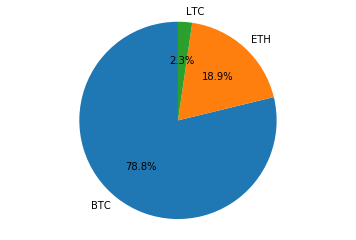

In [18]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = altfundX['SYMBOL']
sizes = altfundX['allocation_rounded_percent']
#explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()